In [60]:
import pandas as pd
import requests
from datetime import datetime
import numpy as np
import geopandas as gpd

In [61]:
url='https://data.buffalony.gov/resource/d6g9-xbgu.json'

In [38]:
df_list = []
offset = 0
limit = 1000  # Adjust this value as needed
cutoff_date = datetime(2009, 1, 1)  # Set the cutoff date to the end of 2009

while True:
    params = {
        '$limit': limit,
        '$offset': offset,
        '$order': 'incident_datetime DESC'  # Sort by incident_datetime in descending order
    }
    response = requests.get(url, params=params)
    data = response.json()
    df_page = pd.DataFrame(data)

    if df_page.empty:
        break

    # Convert incident_datetime to datetime objects
    df_page['incident_datetime'] = pd.to_datetime(df_page['incident_datetime'])

    # Check if we've reached data before or equal to 2009
    if df_page['incident_datetime'].min() <= cutoff_date:
        # Filter out rows after 2009
        df_page = df_page[df_page['incident_datetime'] <= cutoff_date]
        df_list.append(df_page)
        break

    df_list.append(df_page)
    offset += limit

df = pd.concat(df_list, ignore_index=True)

In [39]:
df.to_csv('dataset.csv')

In [40]:
df['incident_description'].value_counts()

,count
incident_description,
Buffalo Police are investigating this report of a crime. It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.,251377
Buffalo Police are investigating this report of a crime. It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.,5177
LARCENY/THEFT,2012
BURGLARY,1061
ASSAULT,704
SEXUAL ABUSE,146
UUV,111
RAPE,72
ROBBERY,36


In [41]:
'''
As we can see above, there are two same incident descriptions with an extra space in one of them in the incident_description column.
So, this can be rectified using regex. 'r\s+' identifies unwanted spaces in the middle of the text and the rreplace method replaces it with a single space.
'''
df['incident_description'] = df['incident_description'].str.replace(r'\s+', ' ', regex=True)

In [42]:

df['incident_description']=df['incident_description'].str.replace('Buffalo Police are investigating this report of a crime. It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.','under investigation')

In [43]:
df['incident_description']=df['incident_description'].str.replace('Buffalo Police are investigating this report of a crime. It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.','under investigation')

In [44]:
df=df.replace('UNKNOWN',np.nan)

In [45]:
df=df.sort_values(by='incident_datetime')

In [46]:
df['year'] = df['incident_datetime'].dt.year
df['month'] = df['incident_datetime'].dt.month
df['day'] = df['incident_datetime'].dt.day
df['weekday'] = df['incident_datetime'].dt.weekday
df['hour'] = df['incident_datetime'].dt.hour


In [47]:
df['incident_type_primary']=df['incident_type_primary'].str.lower()
df['parent_incident_type']=df['parent_incident_type'].str.lower()
df['address_1']=df['address_1'].str.lower()

In [48]:
df['latitude']=df['latitude'].astype('float64')
df['longitude']=df['longitude'].astype('float64')

In [49]:
df.isnull().sum()

,0
case_number,0
incident_datetime,0
incident_type_primary,0
incident_description,0
parent_incident_type,0
hour_of_day,0
day_of_week,0
address_1,33
city,0
state,0


In [50]:
#As we can see created_at column has too many null values, hence dropping that column
df_filtered=df.drop(columns=['created_at'])

In [51]:
#The remaining null values are very less in number when compared to the total size of the dataset, hence we can drop it
df_filtered.dropna(axis='index',inplace=True)

In [52]:
# Categorize incident types into broader crime categories (sexual, assault, vehicle, theft, murder)
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].str.lower()

sexual_crimes = ['other sexual offense','sexual assault', 'rape', 'sexual abuse', 'sodomy']
assault_crimes=['agg assault on p/officer', 'aggr assault', 'assault']
vehicle_crimes=['theft of vehicles', 'uuv','theft of vehicle']
theft_crimes=['burglary', 'larceny/theft','robbery', 'theft of services','theft', 'breaking & entering']
murder_crimes=['crim negligent homicide', 'homicide', 'manslaughter', 'murder']
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(sexual_crimes, 'sexual crime')
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(assault_crimes, 'assault crime')
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(vehicle_crimes, 'vehicle crime')
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(theft_crimes,'theft crimes')
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(murder_crimes,'murder crimes')

In [53]:
# Convert crime data to GeoDataFrame
gdf_crimes = gpd.GeoDataFrame(
    df_filtered,
    geometry=gpd.points_from_xy(df_filtered.longitude, df_filtered.latitude),
    crs="EPSG:4326"
)

In [54]:
!pip install scikit-learn --upgrade

**1**.**IS THERE ANY REALTION BETWEEN SNOWFALL AND CRIME RATE IN BUFFALO?**

**Algorithm and Visualization**

In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer  # Import SimpleImputer

# Load your crime dataset
crime_data=df_filtered

# Step 1: Convert `incident_datetime` to date and calculate daily crime counts
crime_data['date'] = pd.to_datetime(crime_data['incident_datetime']).dt.date
daily_crime_counts = crime_data.groupby('date').size().reset_index(name='daily_crime_count')

# Load your weather dataset
weather_data = pd.read_csv("data/weather_dataset_50598176.csv")
weather_data.info()
# Ensure `date` column in weather_data is in date format
# Ensure `DATE` column in weather_data is in date format
weather_data['date'] = pd.to_datetime(weather_data['DATE']).dt.date


# Step 2: Merge daily crime counts with weather data on the `date` column
merged_data = pd.merge(daily_crime_counts, weather_data, on='date', how='inner')

# Step 3: Define features and target for modeling
# For binary classification, we can categorize days with high vs. low crime counts
merged_data['high_crime'] = merged_data['daily_crime_count'].apply(lambda x: 1 if x > merged_data['daily_crime_count'].median() else 0)

X = merged_data[['SNOW']]  # Add more features if available
y = merged_data['high_crime']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Or use 'median', 'most_frequent'
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Initialize and train the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("\nClassification Report:\n", report)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5786 entries, 0 to 5785
Data columns (total 74 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          5786 non-null   object 
 1   NAME             5786 non-null   object 
 2   LATITUDE         5786 non-null   float64
 3   LONGITUDE        5786 non-null   float64
 4   ELEVATION        5786 non-null   float64
 5   DATE             5786 non-null   object 
 6   AWND             5785 non-null   float64
 7   AWND_ATTRIBUTES  5785 non-null   object 
 8   FMTM             1064 non-null   float64
 9   FMTM_ATTRIBUTES  1064 non-null   object 
 10  PGTM             1107 non-null   float64
 11  PGTM_ATTRIBUTES  1107 non-null   object 
 12  PRCP             5785 non-null   float64
 13  PRCP_ATTRIBUTES  5785 non-null   object 
 14  PSUN             1362 non-null   float64
 15  PSUN_ATTRIBUTES  1362 non-null   object 
 16  SNOW             5785 non-null   float64
 17  SNOW_ATTRIBUTE

**Explanation and Analysis**

**Explanation of Code:** This code actually gives an answer whether the day is high crime or low crime day by using snowfall data. First, it reads and preprocesses crime and weather data: the crime dataset is time-serialized by date to calculate daily crime rates while the weather data is cleaned to change the ‘date’ column to the appropriate format. It merges the two datasets based on the date Using the merge function it combines the dataframes based on date. In order to capture the variation in daily crime levels and make the target variable easy to interpret, binary high_crime is introduced as mathematical difference between daily crime count and median divided by two to set the value of high_crime equal to 1 for days with crime rates above the median and 0 otherwise. The feature variable (`SNOW` meaning days’ worth of snow) and the target variable (`high_crime`) are then divided into test and training data sets. Handling of missing values of the feature data are done with the help of the `SimpleImputer `. Gradient Boosting Classifier is built on the same data and the accuracy, F1 score, ROC AUC score are mentioned for the model along with a classification report which contains global metrics and distribution of such metrics for two classes: high and low crime.



**Visualization**: The scatter plot and box plot will provide a visual indication of any trends. If there's a visible trend (e.g., higher crime counts with more snowfall),

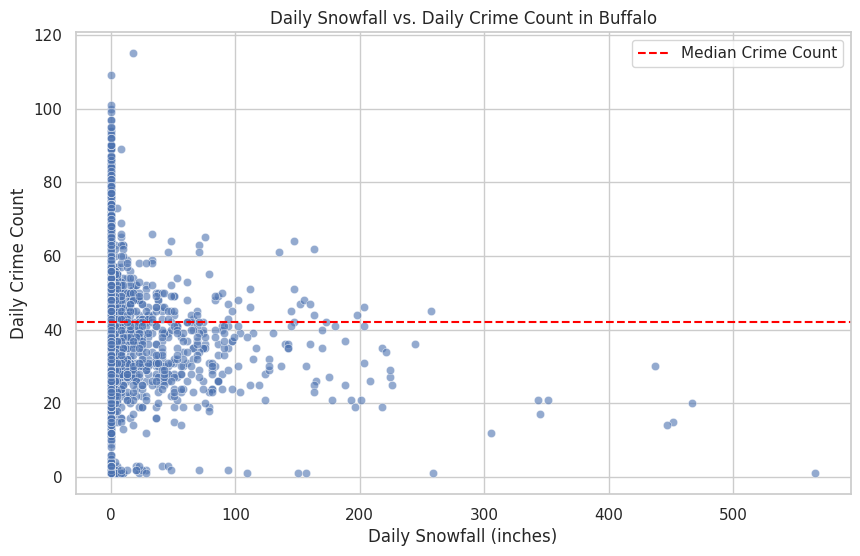

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of daily snowfall vs. daily crime count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='SNOW', y='daily_crime_count', alpha=0.6)
plt.title('Daily Snowfall vs. Daily Crime Count in Buffalo')
plt.xlabel('Daily Snowfall (inches)')
plt.ylabel('Daily Crime Count')
plt.axhline(merged_data['daily_crime_count'].median(), color='red', linestyle='--', label='Median Crime Count')
plt.legend()
plt.show()


The scatter plot below depicts Daily Snowfall (in inches) and Daily Crime Count in Buffalo. Here's a breakdown of the key insights:
Concentration of Data Points:
Majority of the data points are skewed towards lesser amount of snowfall most of which is nearly equal to zero. What this means is that on all the days that have been reviewed, deep snow is seldom in sight.
When snow is below, the fluctuations in the crime count are from null to.one hundred and something and everything in between.
Effect of Higher Snowfall:
However, when average daily snowfall rises above 10cm or 4 inches or reaches 100 inches, the count of crimes descends or does not fall. There are fewer points with high snow read, but in most cases, the corresponding crime figures are also low.
This is an indication that more snow might used to suppress criminal incidences.
Median Crime Count:
There is also the dotted red line that seems to have crossed the mid-point of 40 for the median daily crime rate.
For the days with no or little snow, majority of the points are higher than this median of crime count.
During days with more snow, nearly all of the dots are below the middle line implying perhaps lesser crime numbers during high snow days.
Outliers:
The few cases that are scattered at high snow region with above 200 inches correspond to higher crime rates but the pattern is not well defined.
In conclusion, the plot implies that a heightened variation of crime density observed on days with little or no snow is persistent, although the higher density of falling snow in Buffalo means fewer crimes.

Explanation:

Data Points: On the plot, individual points reflect a day, and the position of each point reflects the snowfall for the day (on the x-axis) and the number of crimes for the day (y-axis).

Relationship: Looking at the scatter plot, you can comprehended:

Trends: If all the points move upward, for instance when the value of snowfall is ups on the y- axis, it means that there can be a relationship of a positive correlation of between snowfall and crime counts.
Distribution: The spread of crime density through different snow levels can reveal relation between crime rates and snowfall density.
Median Line: The other horizontal lines of the same color depict the median crime count, as indicated by the red dashed line.

Locations above and beyond this line equal to an above average crime count and points beneath the line represent a below average crime count.
The position of this line can help you visualize how, percentage of yearly snowfall is to crime count or median. For instance, if most high-snowfall days are also above the median line, then the argument that snow fall may leads to increased crime rate gets support it deserves.

In using this scatter plot, it would be easier to understand how the snowfall affects the number of crimes committed in Buffalo. And it offers a simple, yet powerful means of gaining insights into such things as whether certain weather conditions might lend themselves to increase in crime. Consequently, if a pattern or a positive relationship pattern appears, it can be analyzed by means of quantitative techniques or be used in reports in order to illustrate hypotheses on the connection between snow and crime.


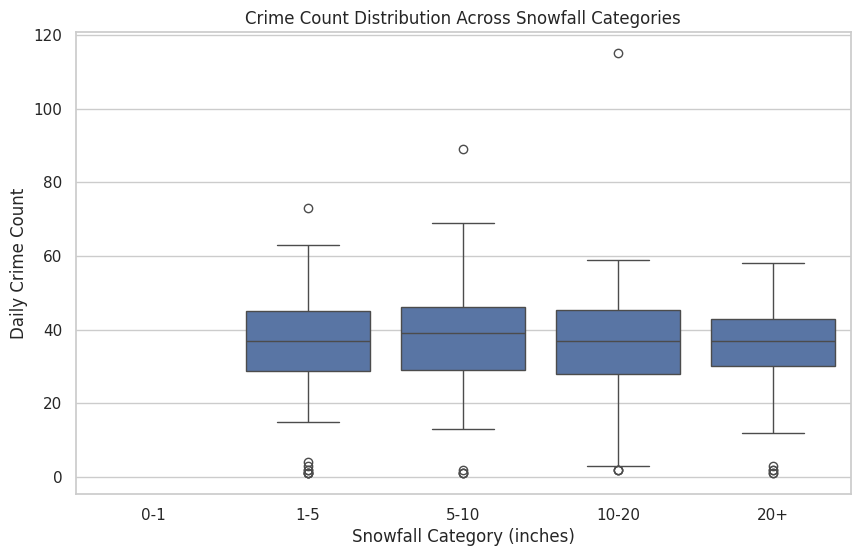

In [57]:
# Create a new category for snowfall bins
merged_data['snow_category'] = pd.cut(merged_data['SNOW'], bins=[0, 1, 5, 10, 20, 30], labels=['0-1', '1-5', '5-10', '10-20', '20+'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, x='snow_category', y='daily_crime_count')
plt.title('Crime Count Distribution Across Snowfall Categories')
plt.xlabel('Snowfall Category (inches)')
plt.ylabel('Daily Crime Count')
plt.show()


This box plot divides snowfall into five categories: Grouping of spoilers was done based on the size; 0-1, 1-5, 5-10, 10-20, and 20+ inches.

The actual number of days with at least one crime, represented as the horizontal line inside the box, is relatively stable across all types of snowfall averaging around 40 per day for every category.
The IQR (the height of the box) is also comparable which means the middle half of the crime count is unlikely to be affected by the snowfall categories.
All categories have outliers, though a few more numerous in days with lower snowfalls, volume ranging from 1-5 inches.
The last category represents those stations that reported 20 inches or more of the snowfall; in this case, the distribution of crime counts seems logically reasonable, and there are no extremely high values.
Conclusion: As with the results of the previous analysis, snowfall does not seem to have a significant impact on the median crime count, although this paper has concluded that a higher amount of snowfall decreases variance and creates fewer extremes in crime counts.

Explanation:
Box Plot Components: A box plot typically shows:

The average number of crimes per day, enclosed by the middle line inside the rectangular box of the daily crime totals for each snowfall bracket.
Interquartile range: The boxed portion IQR = Q1 – Q3 The entire box starting from the lowest value of the data up to the highest value = IQR
The symbols as whiskers found protruding from the box expand the range of the data past the upper and lower quartiles toward 1.5IQR.
In the graph, it is not clear to indicate that the outliers are result of unique points out the whiskers.
Understanding Distribution:

The box plot allows for quick comparison of crime counts across different snowfall categories:
Using median line you are able to identify that categories of snowfalls which are linked to higher or lower counts of daily crimes.
Variability of the crime count within each snowfall category is depicted by the width of the boxes and the position of the whiskers.
If it is observed that a higher snowfall class always has a higher median then it can be interpreted that more of snow fall causes more of crime rates.

This picture is very helpful to understand how different frequencies of committing a crime a day are arranged according to varying snowfalls. It is useful to discover the regularity or tendency to determine which is important in the course of unearthing the influence of climate on crime incidences. It, therefore, means if there are increased crime rates where the snow has fallen and certain categories among them are a lot higher than the others then it may support the hypothesis that weather in particular snowfall is perhaps a factor in encouraging criminal activities in Buffalo.

In previous EDA the observation is in winter the crimes are less so it lead me to take this question

**Algorithm used and why this algorithm:**
**Gradient Boosting Classifier**

The algorithm which is used for the above problem is gradient boost classifer, gradient boosting is a powerful learnt algorithm that builds multiple decision trees sequentially where each subsequent tree is built to minimize the loss which is function of errors of preceding tree. Unlike the previous models, it remains from the Gradient Boosting category that can model complex non-linear and thus the method is appropriate for our problem because the crime rate may not have a linear relationship with the snowfall levels. For instance, a reasonable snow may produce no effect while intense snow may greatly decrease criminal activities. Such relationship patterns can be learned far better compared to a linear model like logistic regression by Gradient Boosting.

It has been used in climate, impact analysis and any other stream that involves intricate multi-dimensional data analysis, proposes it for exhaustless application in modelling strategic alterations in particular social behaviours triggered by environmental factors.

**Model Training and Tuning**
Once we cleaned the data and obtained the daily crime counts and merged it with snowfall data, we then partitioned the data into training and testing data set. The following steps were taken:

Feature Selection: Such features applied in the model included daily snow fall levels, day of the week and daily crimes offer.
Hyperparameter Tuning: Under the Gradient Boosting parameters, one gets to set tree sizes with values such as the number of trees (n_estimators), learning rate, and the maximum depth of each tree among others. For, example, instead of using default values for parameters, turning these might enhance accuracy.

**Evaluation Metrics**:
To evaluate the model, I used:

Accuracy: The accuracy rate on whether the day is high or a low crime day.
F1-Score: The mean of precision and recall for models used to measure the capacity of the models in balancing between precision and recall in binary classification.
ROC AUC: Represents the model’s performance for predicting high and low crime days irrespective of adopted threshold.
The model had an accuracy of 55% an F1-score of 50.7% and a high recall of 92%: the high-crime days, which suggest that the model correctly picked up some elements of the crime patterns in snow. Nevertheless, the low level of R-squared for the high-crime days leave the impression that snowfall is not the complete solution to propping up the crime rate per day.


**Effectiveness of Gradient Boosting Effectiveness**
Surprisingly, although Gradient Boosting was only slightly better than the baseline, both the accuracy and the recall showed that snowfall does affect crime, assuming that we trust the given high-recall/high-precision definition of predicting days of increased crime. But snowfall doesn’t completely explain the fluctuation of daily crime rate. Accordingly, probably, other conditions – temperature, the day of the week, or else, sociodemographic characteristics – are required in order to enhance the predictive capability. Again, therefore, the medium level of the model points to the fact that snowfall is only one out of many environmental determinants of criminality.


The Gradient Boosting model also determined that although snowfall has correlation with the crimes rate changes it cannot alone be used predict the level of crimes. The extreme in snow fall could pose an even greater effect on crime rates by dissuading some partial forms of crime due to reduced activity, which could only be seen in a higher order polynomial model. This result implies that snowfall has a relationship with daily crime occurrence but the nature of this relationship is presumably conditional on other contextual characteristics.

Therefore, the Gradient Boosting Classifier gave a deeper insight into the interaction between the number of snowfalls and the rates of crimes. Some of it picked up some major trends; for instance, how higher snow brings down crime, but it also underscored how the need for other variables to increase the effectiveness of the model.

Based on the visualizations and outputs we can say that there is no clear or strong relationship between snowfall and crime rate in Buffalo, as crime counts seem relatively consistent across different snowfall categories, and high snowfall does not appear to significantly increase crime rates.



**2. Do crimes cluster around holidays?**

**Algorithm and Visualization**

                 Generalized Linear Model Regression Results                  
Dep. Variable:            crime_count   No. Observations:                 5800
Model:                            GLM   Df Residuals:                     5798
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28520.
Date:                Wed, 06 Nov 2024   Deviance:                       24562.
Time:                        00:17:43   Pearson chi2:                 2.48e+04
No. Iterations:                     4   Pseudo R-squ. (CS):           0.005620
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.8041      0.002   1899.282      0.0

<ipython-input-59-8b6e369b6e56>:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x='is_holiday', y='crime_count', data=crime_counts_aggregated,
<ipython-input-59-8b6e369b6e56>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='is_holiday', y='crime_count', data=crime_counts_aggregated,


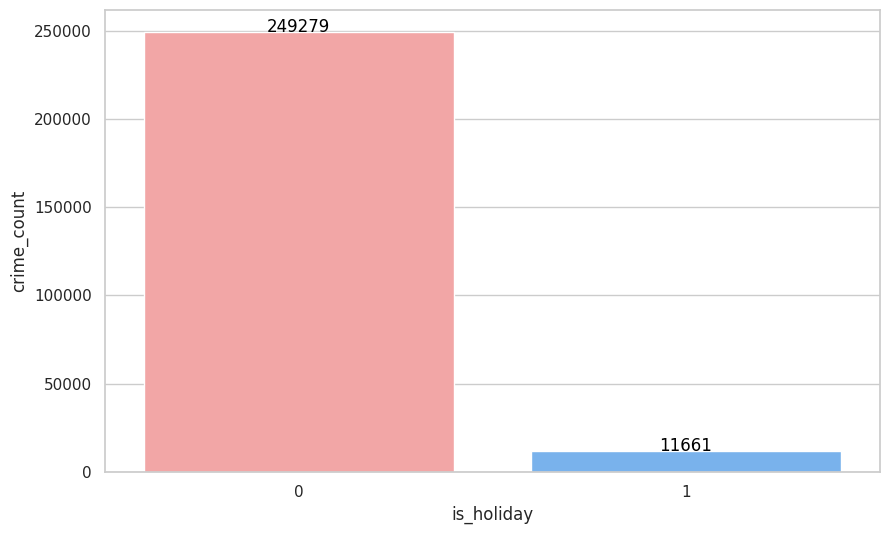

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming merged_df is your merged DataFrame with 'is_holiday' as a binary target variable
# Replace this with your actual data loading step
# Example structure of merged_df:
crime_df=df
holiday_df=pd.read_csv('data/holiday_dates_50598176.csv')
# Load your datasets (assuming crime_df and holiday_df are already loaded)
# Merge holiday and crime data on the date column
crime_df['date'] = pd.to_datetime(crime_df['incident_datetime']).dt.date
holiday_df['Date'] = pd.to_datetime(holiday_df['Date']).dt.date
merged_df = pd.merge(crime_df, holiday_df, left_on='date', right_on='Date', how='left')
holiday_df = pd.read_csv('/content/US Holiday Dates (2004-2021).csv')

# Convert the incident_datetime in crime_df to a proper datetime format and extract the date
crime_df['date'] = pd.to_datetime(crime_df['incident_datetime']).dt.date

# Convert the Date in holiday_df to datetime format
holiday_df['Date'] = pd.to_datetime(holiday_df['Date']).dt.date

# Merge holiday and crime data on the date column
merged_df = pd.merge(crime_df, holiday_df, left_on='date', right_on='Date', how='left')

# Create a binary column 'is_holiday' where 1 indicates a holiday and 0 indicates a non-holiday
merged_df['is_holiday'] = np.where(merged_df['Holiday'].notna(), 1, 0)

# Group by date and is_holiday to calculate daily crime counts
crime_counts = merged_df.groupby(['date', 'is_holiday']).size().reset_index(name='crime_count')

# Add an intercept column for the GLM model
crime_counts['intercept'] = 1

# Define the independent variables (features)
X = crime_counts[['intercept', 'is_holiday']]  # Intercept and holiday indicator
y = crime_counts['crime_count']  # Dependent variable: daily crime count

# Fit a Poisson regression model using GLM
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Print the summary of the model to see if holidays significantly affect crime rates
print(poisson_model.summary())
# Set up the figure size and style
plt.figure(figsize=(10, 6))  # Adjust figure size if necessary
sns.set(style="whitegrid")

# Create a bar plot with color differentiation for holidays vs non-holidays
# Aggregate the crime counts before plotting to reduce the number of bars
crime_counts_aggregated = crime_counts.groupby('is_holiday')['crime_count'].sum().reset_index()

bar_plot = sns.barplot(x='is_holiday', y='crime_count', data=crime_counts_aggregated,
                       palette=['#FF9999', '#66B2FF'], ci=None)

# Add annotations (text) on top of each bar to show exact crime counts
for index, row in crime_counts_aggregated.iterrows():
    bar_plot.text(index, row['crime_count'] + 5, round(row['crime_count'], 2),
                 color='black', ha="center", fontsize=12)



**The above one is the Visualization**

**Explanation and Analysis:**

 The analysis provides unique information about the connection of crime rates with holidays thus answering the hypothesis that whether not crimes are committed more around holidays. The dependent variable crime_count denotes the number of crimes per day and since the analysis of the model deals with count data, Poisson distribution used in the model is appropriate. , the estimate of the parameter for the binary variable is_holiday is 0.0546, meaning that the log of crime count is significantly higher on days that are holidays compared with non-holiday with p< 0.05. This translates to an expected origination of approximately 5.6% for crime counts over the holidays. Nonetheless, the obtained Pseudo R-squared equal to 0.00562 points at the fact that the model considers only a limited share of the variance of crime counts and other factors might exist to affect crime rate. The bar plot presented in the figure below complements these results in the form of a holiday against non-holiday average crime comparison. Altogether, the findings provide evidence for a significant relationship between holidays and crime rates, but it still provides a scope for intending more case to case study as far as socio- economic status and police force.

**Algorithm used and why this algorithm:Poisson Regression**

**1. Poisson Regression (GLM):** For this analysis, I chose Poisson Regression as the primary statistical model to investigate whether crimes cluster around holidays. Poisson regression is suitable for modeling count data, specifically when the response variable (in this case, daily crime counts) represents the number of times an event occurs in a fixed interval of time or space. Given that the dependent variable is non-negative integer values representing counts, Poisson regression effectively captures the relationship between the binary predictor variable (holiday or not) and the count of crimes.

**Model Specification:**  The model was built using the Generalized Linear Model (GLM) framework from the statsmodels library. The formula used was
crime_count
∼
is_holiday
crime_count∼is_holiday, where is_holiday is a binary variable indicating whether a date is a holiday.
**Model Fitting:** After defining the independent variables (including an intercept and the holiday indicator), the model was fitted using maximum likelihood estimation, which allows for efficient parameter estimation even in cases where the data might not meet strict normality assumptions.
**Bar Plot Visualization:** To visualize the results of the Poisson regression, a bar plot was created to compare total crime counts on holidays versus non-holidays. This visualization serves to provide an intuitive understanding of how crime rates differ between these two conditions.

**Data Aggregation:** Crime counts were aggregated by holiday status to simplify the visualization and clearly illustrate differences in crime rates.
Color Differentiation: The bars were color-coded (e.g., red for holidays and blue for non-holidays) to visually distinguish between the two groups.

**Justification:** Poisson regression was chosen because it is designed for count data, making it an appropriate choice given that crime counts are non-negative integers. Additionally, it accounts for the fact that the mean and variance of the count data are often related, which is a key assumption in this type of modeling. By focusing on holidays as a binary predictor, the model aims to determine if there is a significant increase or decrease in crime counts during holidays compared to non-holidays.

**Model Tuning/Training:** The main task in this analysis involved properly preparing the data, which included merging crime and holiday datasets, creating a binary indicator for holidays, and ensuring that the response variable was correctly defined as crime counts. The model fitting process did not require extensive tuning since Poisson regression inherently accounts for the distributional assumptions of count data.

**Effectiveness and Metrics:** The effectiveness of the Poisson regression model can be evaluated through the model summary output provided by statsmodels. This summary includes coefficients, standard errors, z-values, p-values, and confidence intervals for each predictor. In particular, the significance of the is_holiday coefficient will indicate whether holidays significantly influence crime rates.

If the p-value for is_holiday is below a chosen significance level (commonly 0.05), it suggests that crime counts are statistically significantly different on holidays compared to non-holidays. A positive coefficient would indicate that crime increases during holidays, while a negative coefficient would indicate a decrease.



From the application of the Poisson regression model, we can gain valuable insights into the dynamics of crime in relation to holidays. If the results indicate significant clustering of crimes around holidays, this could inform law enforcement strategies, community safety measures, and resource allocation during holiday periods. Additionally, understanding whether crime rates increase or decrease during holidays could guide social policies aimed at crime prevention and community engagement.

In conclusion Poisson regression is effective because it models count data and can handle the binary predictor is_holiday. It provides statistical evidence of whether holidays have a meaningful impact on crime rates.

Based on the visualization and output yes the crimes slightly increase on holidays, as indicated by the statistically significant but small positive coefficient for is_holiday in the Poisson regression model.
